In [1]:
%pylab inline
import pandas as pd

import plotnine as p

Populating the interactive namespace from numpy and matplotlib


C:\Users\vale\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
s_sample_info = pd.read_csv('Segerstolpe%2Fsegerstolpe_sample_info.csv')

In [3]:
s_long_exprs = pd.read_csv('Segerstolpe%2Fsegerstolpe_long_exprs.csv')

In [4]:
s_exprs = s_long_exprs.pivot(index='cell', columns='gene')['log2cpm'].fillna(0)
s_exprs = s_exprs.loc[s_sample_info['cell']]

In [5]:
s_sample_info = s_sample_info.set_index('cell', drop=False)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(s_exprs, s_sample_info['cell_type1'], test_size=.2)

In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
lr = LogisticRegression(C=0.05, penalty='l1', n_jobs=-1)

In [10]:
lr.fit(X_train, y_train)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [11]:
lr.classes_

array(['MHC class II', 'PSC', 'acinar', 'alpha', 'beta', 'co-expression',
       'delta', 'ductal', 'endothelial', 'epsilon', 'gamma', 'mast',
       'not applicable', 'unclassified', 'unclassified endocrine'], dtype=object)

In [12]:
lr.coef_.shape

(15, 23171)

In [13]:
y_hat = lr.predict(X_train)

In [14]:
y_hat

array(['ductal', 'alpha', 'not applicable', ..., 'not applicable', 'beta',
       'not applicable'], dtype=object)

In [15]:
lr.score(X_train, y_train)

0.98256848096762717

In [16]:
lr.score(X_test, y_test)

0.92887624466571839

In [17]:
from sklearn import metrics

In [18]:
pd.DataFrame.from_records(metrics.confusion_matrix(y_train, y_hat), index=lr.classes_)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
MHC class II,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
PSC,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0
acinar,0,0,142,1,0,0,0,0,0,0,0,0,0,0,0
alpha,0,0,0,711,0,0,0,0,0,0,0,0,0,0,0
beta,0,0,0,0,227,0,0,0,0,0,0,0,0,0,0
co-expression,0,0,0,2,2,25,1,0,0,0,0,0,0,0,0
delta,0,0,0,0,0,0,94,0,0,0,0,0,0,0,0
ductal,0,0,0,0,0,0,0,301,0,0,0,0,0,0,0
endothelial,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0
epsilon,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0


In [19]:
sparsity = np.mean(lr.coef_.ravel() == 0) * 100
sparsity

99.583099564110313

In [21]:
marker_genes = pd.DataFrame({
    'cell_type': lr.classes_[lr.coef_.argmax(0)],
    'gene': X_train.columns,
    'weight': lr.coef_.max(0)
})

In [22]:
marker_genes.query('weight > 0.').shape

(628, 3)

In [23]:
top_markers = \
marker_genes \
    .query('weight > 0.') \
    .sort_values('weight', ascending=False) \
    .groupby('cell_type') \
    .head(6) \
    .sort_values(['cell_type', 'weight'], ascending=[True, False])

In [24]:
top_markers.shape

(72, 3)

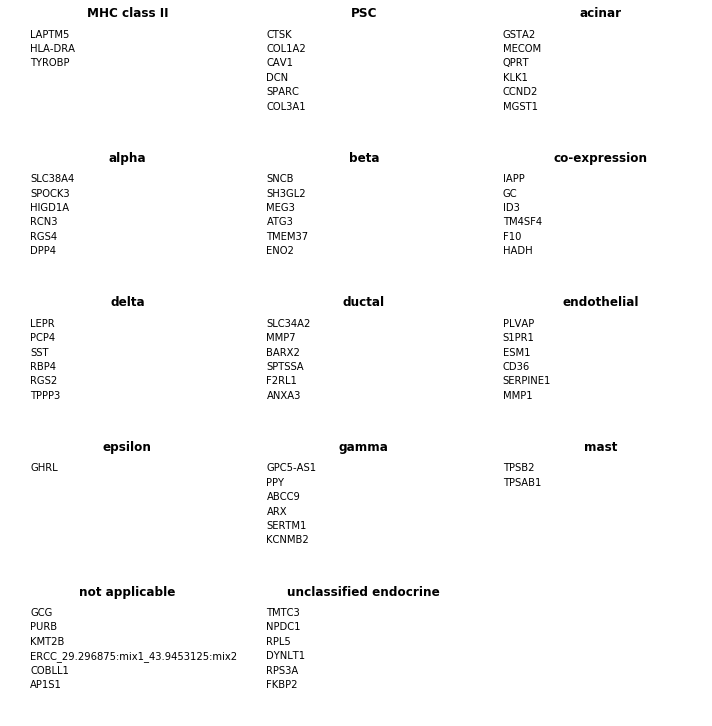

In [25]:
figsize(10, 20)
for i, m in enumerate(top_markers.cell_type.unique()):
    plt.subplot(10, 3, i + 1)
    g = top_markers.query('cell_type == @m')
    plt.title(m, size=12, weight='bold')
    for j, gn in enumerate(g.gene):
        plt.annotate(gn, (0, 0.2 * j), )
        
    plt.axis('off')
    plt.ylim(6 * 0.2, -0.2)
    
plt.tight_layout()

In [26]:
shift_idx = y_train.argsort()
sorted_idx = y_train.sort_values().index

In [27]:
y_prob = lr.predict_log_proba(X_train.loc[sorted_idx])

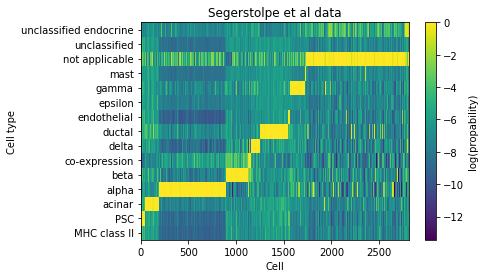

In [28]:
figsize(6, 4)
plt.pcolor(y_prob.T, vmax=0)
plt.yticks(0.5 + np.arange(lr.classes_.shape[0]), lr.classes_);
plt.colorbar(label='log(propability)');
plt.ylabel('Cell type')
plt.xlabel('Cell');
plt.title('Segerstolpe et al data');

In [29]:
set(lr.classes_) - set(np.unique(lr.classes_[y_prob.argmax(1)]))

{'unclassified'}

In [30]:
m_sample_info = pd.read_csv('Muraro%2Fmuraro_sample_info.csv')

In [31]:
m_long_exprs = pd.read_csv('Muraro%2Fmuraro_long_exprs.csv')

In [32]:
m_exprs = m_long_exprs.pivot_table(index='cell', columns='gene')['log2cpm'].fillna(0)

In [33]:
m_exprs = m_exprs.loc[m_sample_info['cell']]

In [34]:
m_sample_info = m_sample_info.set_index('cell', drop=False)

In [35]:
X_new = m_exprs.T.loc[X_train.columns].T.fillna(0)

In [36]:
m_sample_info['predicted_cell_type'] = lr.predict(X_new)

In [37]:
m_sample_info \
    .groupby(['cell_type1', 'pred_cell_type']) \
    .count().iloc[:, [0]] \
    .unstack().T \
    .fillna(0)

cell_type1                   acinar  alpha   beta  delta  ductal  endothelial  \
     pred_cell_type                                                             
cell MHC class II               0.0    0.0    0.0    0.0     2.0          0.0   
     PSC                        0.0    0.0    1.0    0.0     3.0          1.0   
     acinar                   212.0    1.0    2.0    0.0     7.0          0.0   
     alpha                      0.0  595.0    2.0    0.0     0.0          0.0   
     beta                       0.0    0.0  359.0    2.0     0.0          0.0   
     co-expression              0.0   18.0   17.0    2.0     0.0          0.0   
     delta                      0.0    0.0    2.0  175.0     0.0          0.0   
     ductal                     0.0    5.0    3.0    0.0   208.0          0.0   
     endothelial                0.0    0.0    0.0    0.0     0.0         11.0   
     epsilon                    0.0    0.0    0.0    0.0     0.0          0.0   
     gamma                      0.0    1.0    5.0    0.0     1.0          0.0   
     mast                       0.0    0.0    0.0    0.0     1.0          0.0   
     not applicable             6.0  192.0   42.0   12.0    22.0          9.0   
     unclassified endocrine     1.0    0.0   15.0    2.0     1.0          0.0   

cell_type1                   epsilon  gamma  mesenchymal  unclear  
     pred_cell_type                                                
cell MHC class II                0.0    0.0          0.0      0.0  
     PSC                         0.0    0.0         77.0      0.0  
     acinar                      0.0    2.0          0.0      0.0  
     alpha                       0.0    0.0          0.0      0.0  
     beta                        0.0    0.0          0.0      0.0  
     co-expression               0.0    0.0          0.0      0.0  
     delta                       0.0    0.0          0.0      0.0  
     ductal                      0.0    0.0          1.0      3.0  
     endothelial                 0.0    0.0          0.0      0.0  
     epsilon                     3.0    0.0          0.0      0.0  
     gamma                       0.0   80.0          0.0      0.0  
     mast                        0.0    0.0          0.0      0.0  
     not applicable              0.0   19.0          2.0      1.0  
     unclassified endocrine      0.0    0.0          0.0      0.0